In [1]:
import os
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from nordpool import elspot, elbas
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Swedish Power Pricing-Daily

In [2]:
def Date_Capture(area):    
    prices_spot = elspot.Prices()
    begin_day=datetime.datetime(2019,1,1)
    end_date=datetime.datetime.now()
    Prices=[]
    while begin_day<end_date:
        Prices.extend(prices_spot.daily(end_date=end_date,areas=[area])['areas'][area]['values'])
        end_date=end_date-datetime.timedelta(days=31)

    price={}
    for n,i in enumerate(Prices):
        price[Prices[n]['end']]=Prices[n]['value']

    Price=pd.DataFrame.from_dict(price, orient='index').reset_index()
    Price.columns=['Date',area]

    Price['Date']=[datetime.datetime.strptime(str(time.replace(tzinfo=None)),'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d') for time in Price['Date']]

    Price=Price.sort_values(by = "Date",ascending=True).reset_index(drop=True).set_index('Date')
    return Price

In [3]:
SE1=Date_Capture('SE1')
SE2=Date_Capture('SE2')
SE3=Date_Capture('SE3')
SE4=Date_Capture('SE4')

In [4]:
EP=pd.concat([SE1,SE2['SE2'],SE3['SE3'],SE4['SE4']],axis=1)

In [5]:
EP.head()

,SE1,SE2,SE3,SE4
Date,,,,
2021-01-01,26.17,26.17,26.17,36.24
2021-01-02,31.58,31.58,31.58,43.17
2021-01-03,25.78,25.78,25.78,27.31
2021-01-04,42.17,42.17,42.17,43.88
2021-01-05,47.29,47.29,47.29,47.29


# 2.  Net Import Electricity-Yearly

In [6]:
dir_name = 'figure'
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)

In [7]:
net_imp=pd.read_csv('./Data/net import/net-electricity-imports.csv')

In [8]:
se_imp=net_imp[net_imp['Entity'].str.contains('Sweden')]

In [9]:
se_imp.reset_index(drop=True,inplace=True)

In [10]:
ie=[]
for n in se_imp['Net imports (TWh)']:
    if n>0:
        ie.append('import')
    elif n<0:
        ie.append('export')

In [11]:
se_imp.insert(loc=len(se_imp.columns), column='ie', value=ie)

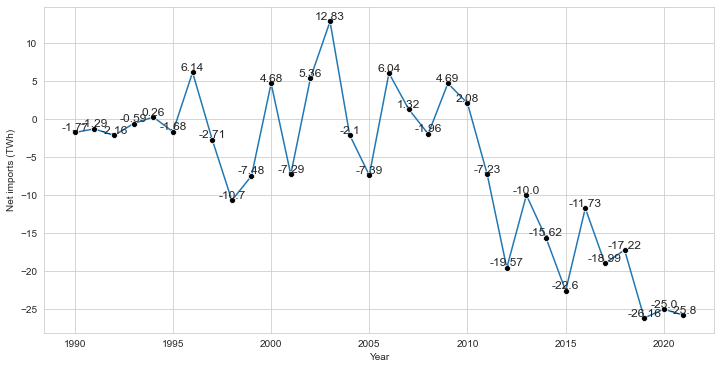

In [12]:
sns.set_style('whitegrid') 
fig = plt.figure(figsize=(12,6))
sns.lineplot(data=se_imp,x='Year',y='Net imports (TWh)',palette='husl',marker='o',markerfacecolor='black')
for a, b in zip(se_imp['Year'], se_imp['Net imports (TWh)']):
    plt.text(a, b, b,ha='center',va='bottom',fontsize=12)
plt.savefig("figure/netimport.png",dpi=600)

In [13]:
dic={se_imp['Year'][n]:se_imp['Net imports (TWh)'][n] for n in se_imp.index}

In [14]:
df=pd.DataFrame.from_dict(dic,columns=['Net imports (TWh)'],orient='index')

In [15]:
df.index.name='Year'

In [16]:
df.to_csv('./Data/net import/netimport.csv')

# 3. Swedish Electricity Mix-Yearly

In [17]:
source=pd.read_csv('./Data/source/share-elec-by-source.csv')

se_source=source[source['Entity'].str.contains('Sweden')]

In [18]:
# se_source=se_source[se_source['Year']>=2012]

In [19]:
se_source.reset_index(drop=True,inplace=True)

In [20]:
newse_source=se_source[['Year','Coal (% electricity)','Gas (% electricity)','Hydro (% electricity)','Solar (% electricity)','Wind (% electricity)','Oil (% electricity)','Nuclear (% electricity)','Other renewables including bioenergy (% electricity)']]

In [21]:
newse_source.head()

,Year,Coal (% electricity),Gas (% electricity),Hydro (% electricity),Solar (% electricity),Wind (% electricity),Oil (% electricity),Nuclear (% electricity),Other renewables including bioenergy (% electricity)
0,1990,0.740,0.288,49.664,0.0,0.007,1.267,46.705,1.329
1,1991,1.334,0.395,43.029,0.0,0.007,1.742,52.228,1.266
2,1992,1.233,0.541,50.935,0.0,0.021,2.350,43.541,1.377
3,1993,1.432,0.626,51.391,0.0,0.034,2.754,42.269,1.494
4,1994,1.829,0.603,41.416,0.0,0.049,3.273,51.268,1.563


In [22]:
new=newse_source.sort_values(by = "Year",ascending=True)

In [23]:
newse_source=new[new['Year']>=2012]

In [24]:
newse_source.set_index(newse_source['Year'],inplace=True)
final_source=newse_source.drop(columns='Year')

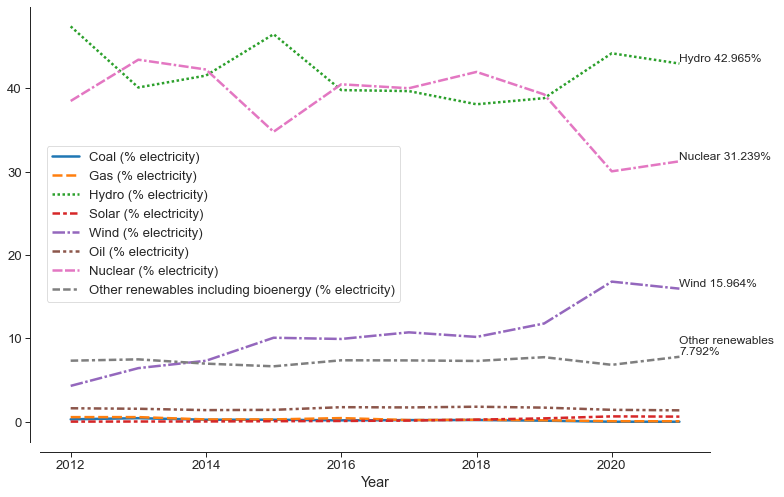

In [25]:
sns.set_style('ticks') 
fig = plt.figure(figsize=(12,8))
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':2.5})
sns.lineplot(data=final_source,linewidth=2.5)
plt.text(2021,final_source.iloc[9,2] , 'Hydro '+str(final_source.iloc[9,2])+'%',ha='left',va='bottom',fontsize=12)
plt.text(2021,final_source.iloc[9,4] , 'Wind '+str(final_source.iloc[9,4])+'%',ha='left',va='bottom',fontsize=12)
plt.text(2021,final_source.iloc[9,6] , 'Nuclear '+str(final_source.iloc[9,6])+'%',ha='left',va='bottom',fontsize=12)
plt.text(2021,final_source.iloc[9,7] , 'Other renewables \n'+str(final_source.iloc[9,7])+'%',ha='left',va='bottom',fontsize=12)
sns.despine(offset=(10,10),trim=False)
plt.savefig("figure/source.png",dpi=600)

In [26]:
new.to_csv('./Data/source/sourceshare.csv',index=False)

# 4. Carbon Price-Daily

In [27]:
excelFile = "./data/carbon/emission-spot-primary-market-auction-report-2019-data.xlsx"
df = pd.read_excel(excelFile,sheet_name= "Primary Market Auction")
data=df.iloc[:,[1,5]]
Data19=data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Data19=Data19.rename(columns=data.iloc[4,:]).drop([3,4],axis=0)

In [28]:
excelFile = "./data/carbon/emission-spot-primary-market-auction-report-2020-data.xlsx"
df = pd.read_excel(excelFile,sheet_name= "Primary Market Auction")
data=df.iloc[:,[1,6]]
Data20=data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Data20=Data20.rename(columns=data.iloc[4,:]).drop([3,4],axis=0)

D:\ProgramData\Anaconda3\envs\daps\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [29]:
excelFile = "./data/carbon/emission-spot-primary-market-auction-report-2021-data.xlsx"
df = pd.read_excel(excelFile,sheet_name= "Primary Market Auction")
data=df.iloc[:,[1,6]]
Data21=data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Data21=Data21.rename(columns=data.iloc[4,:]).drop([3,4],axis=0)

In [30]:
excelFile = "./data/carbon/emission-spot-primary-market-auction-report-2022-data.xlsx"
df = pd.read_excel(excelFile,sheet_name= "Primary Market Auction")
data=df.iloc[:,[1,6]]
Data22=data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Data22=Data22.rename(columns=data.iloc[4,:]).drop([3,4],axis=0)

In [31]:
carbon=pd.concat([Data19,Data20,Data21,Data22])

In [32]:
Carbon=carbon.sort_values(by = "Date",ascending=True).reset_index(drop=True).set_index('Date')

In [33]:
Carbon

,Auction Price €/tCO2
Date,
2019-01-07,23.01
2019-01-08,22.4
2019-01-10,21.4
2019-01-14,21.95
2019-01-15,22.55
...,...
2022-06-16,85.95
2022-06-17,83.0
2022-06-20,83.51


In [34]:
Carbon.to_csv('./data/carbon/Carbon.csv')

supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [35]:
type(Carbon.index[0])

pandas._libs.tslibs.timestamps.Timestamp

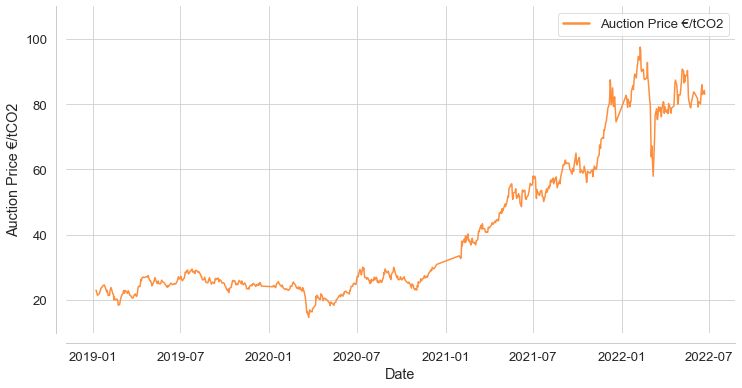

In [36]:
sns.set_style('whitegrid') 
fig=plt.figure(figsize=(12,6))
sns.lineplot(data=Carbon,palette='Oranges_r',linewidth=1.5)
plt.ylim(10,110)
plt.ylabel('Auction Price €/tCO2')
sns.set_context('paper', font_scale=1.5, rc={'lines.linewidth':1.5})
sns.despine(offset=(10,10),trim=False)

# 5. Swedish Weather Data-Daily

In [37]:
w0=pd.read_csv('./data/weather data/sweden 2018-10-01 to 2018-12-31.csv')
w1=pd.read_csv('./data/weather data/sweden 2019-01-01 to 2020-12-31.csv')
w2=pd.read_csv('./data/weather data/sweden 2021-01-01 to 2022-07-01.csv')

In [38]:
w=pd.concat([w0,w1,w2])

In [39]:
w.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,sweden,2018-10-01,11.8,6.8,8.9,11.8,6.0,8.1,6.3,84.4,...,5.7,3,NaN,2018-10-01T06:52:15,2018-10-01T18:21:22,0.70,Rain,Clear conditions throughout the day with late ...,rain,"02486099999,02464099999,02469099999,0248909999..."
1,sweden,2018-10-02,9.7,3.9,7.3,8.3,3.9,6.3,5.3,87.2,...,4.7,2,NaN,2018-10-02T06:54:33,2018-10-02T18:18:25,0.76,Rain,Clear conditions throughout the day with rain.,rain,"02486099999,02464099999,02469099999,0248909999..."
2,sweden,2018-10-03,9.5,5.1,7.1,6.7,2.8,4.7,3.7,80.1,...,4.3,3,NaN,2018-10-03T06:56:52,2018-10-03T18:15:29,0.82,Rain,Clear conditions throughout the day with rain ...,rain,"02486099999,02464099999,02469099999,0248909999..."
3,sweden,2018-10-04,8.9,2.2,5.7,7.3,-0.2,4.0,1.8,77.2,...,4.5,4,NaN,2018-10-04T06:59:11,2018-10-04T18:12:33,0.87,Rain,Clear conditions throughout the day with late ...,rain,"02486099999,02464099999,02469099999,0248909999..."
4,sweden,2018-10-05,16.0,8.4,12.2,16.0,6.4,11.9,6.8,71.4,...,5.9,4,NaN,2018-10-05T07:01:31,2018-10-05T18:09:38,0.92,Rain,Clear conditions throughout the day with morni...,rain,"02486099999,02464099999,02469099999,0248909999..."


In [40]:
w.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [41]:
weather=w.loc[:,['datetime','temp','precip','windspeed']].rename(columns={'datetime':'Date'})

In [42]:
# weather.columns=(['Date','temp','precip','windspeed'])

In [43]:
weather.set_index('Date',drop=True,inplace=True)

In [44]:
weather.to_csv('./data/weather data/weather.csv')

# 6. Electric vehicle-Yearly

In [45]:
EV=pd.read_csv('./data/EV/IEA-EV-data.csv')

In [46]:
SEV=EV[EV['region'].str.contains('Sweden')]

In [47]:
SEV.head()

,region,category,parameter,mode,powertrain,year,unit,value
5693,Sweden,Historical,EV sales,Cars,BEV,2010,sales,4.000000
5694,Sweden,Historical,EV stock,Cars,BEV,2010,stock,4.000000
5695,Sweden,Historical,EV sales share,Cars,EV,2010,percent,0.001296
5696,Sweden,Historical,EV stock share,Cars,EV,2010,percent,0.000100
5697,Sweden,Historical,EV stock share,Cars,EV,2011,percent,0.004419


In [48]:
SEV.value_counts('parameter')

parameter
EV stock              61
EV sales              45
EV stock share        38
EV sales share        31
EV charging points    20
dtype: int64

In [49]:
gp=SEV.groupby('parameter')

In [50]:
groups = {}
for k, g in gp:
    groups[k]=g  
for i in groups:
    groups[i]=pd.DataFrame(groups[i])

In [51]:
EVshare=groups['EV sales share']

In [52]:
EVshare.head()

,region,category,parameter,mode,powertrain,year,unit,value
5695,Sweden,Historical,EV sales share,Cars,EV,2010,percent,0.001296
5698,Sweden,Historical,EV sales share,Cars,EV,2011,percent,0.054493
5700,Sweden,Historical,EV sales share,Vans,EV,2011,percent,0.019393
5715,Sweden,Historical,EV sales share,Vans,EV,2012,percent,0.699425
5717,Sweden,Historical,EV sales share,Cars,EV,2012,percent,0.307963


In [53]:
mode=EVshare.groupby('mode')

In [54]:
EVshare.value_counts('mode')

mode
Cars      12
Vans      11
Buses      6
Trucks     2
dtype: int64

In [55]:
Mode = {}
for k, g in mode:
    Mode[k]=g  
for i in Mode:
    Mode[i]=pd.DataFrame(Mode[i])

In [56]:
EVCarshare=Mode['Cars']

In [57]:
EVCarshare1=EVCarshare.loc[:,['year','value']]

In [58]:
EVCarshare1.columns=(['Date','EVCar_Percent'])
EVCarsaleshare=EVCarshare1.set_index('Date',drop=True)

In [59]:
EVCarsaleshare.to_csv('./data/EV/EVCarsaleshare.csv')

# 7. GDP per capita-Quarterly

In [60]:
GDP=pd.read_csv('./data/gdp per capita/QNA_21072022210426216.csv')

In [61]:
GDP

,LOCATION,Country,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Period,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2018-Q4,Q4-2018,USD,US Dollar,0,Units,NaN,NaN,53873.6,NaN,NaN
1,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2019-Q1,Q1-2019,USD,US Dollar,0,Units,NaN,NaN,53924.6,NaN,NaN
2,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2019-Q2,Q2-2019,USD,US Dollar,0,Units,NaN,NaN,54322.4,NaN,NaN
3,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2019-Q3,Q3-2019,USD,US Dollar,0,Units,NaN,NaN,54650.9,NaN,NaN
4,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2019-Q4,Q4-2019,USD,US Dollar,0,Units,NaN,NaN,55500.8,NaN,NaN
5,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2020-Q1,Q1-2020,USD,US Dollar,0,Units,NaN,NaN,56462.5,NaN,NaN
6,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2020-Q2,Q2-2020,USD,US Dollar,0,Units,NaN,NaN,52276.1,NaN,NaN
7,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2020-Q3,Q3-2020,USD,US Dollar,0,Units,NaN,NaN,56661.4,NaN,NaN
8,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2020-Q4,Q4-2020,USD,US Dollar,0,Units,NaN,NaN,56900.7,NaN,NaN
9,SWE,Sweden,B1_GE,Gross domestic product - expenditure approach,HCPCARSA,"Per Head, US $, current prices, current PPPs, ...",Q,Quarterly,2021-Q1,Q1-2021,USD,US Dollar,0,Units,NaN,NaN,58061.3,NaN,NaN


In [62]:
GDP0=GDP.loc[0:13,['TIME','Value']]

In [63]:
GDP0.columns=(['Date','GDPpercapita (USD)'])

In [64]:
GDP0.set_index('Date',drop=True,inplace=True)

In [65]:
GDP0.to_csv('./data/gdp per capita/GDP0.csv')

In [66]:
GDP1=GDP.loc[14:27,['TIME','Value']]

In [67]:
GDP1.columns=(['Date','GDPpercapita (USD)'])

In [68]:
GDP1.set_index('Date',drop=True,inplace=True)

In [69]:
GDP1.to_csv('./data/gdp per capita/GDP1.csv')

In [70]:
GDP1

,GDPpercapita (USD)
Date,
2018-Q4,53274.9
2019-Q1,53446.2
2019-Q2,53629.2
2019-Q3,53577.5
2019-Q4,53641.9
2020-Q1,53487.0
2020-Q2,49114.0
2020-Q3,52660.0
2020-Q4,52549.8


# 8. Brent Crude Oil-Daily

In [71]:
startDate=datetime.datetime(2019,1,1)
endDate=datetime.datetime(2022,4,30)
Crude=web.DataReader("BZ=F","yahoo",startDate,endDate)

In [72]:
Crude=Crude.Close

In [73]:
Crude

Date
2019-01-02     54.910000
2019-01-03     55.950001
2019-01-04     57.060001
2019-01-07     57.330002
2019-01-08     58.720001
                 ...    
2022-04-25    102.320000
2022-04-26    104.989998
2022-04-27    105.320000
2022-04-28    107.589996
2022-04-29    109.339996
Name: Close, Length: 837, dtype: float64

In [74]:
Crude.to_csv('./data/Crude/Crude.csv',index=True, header=True)

# 9. Natural gas-Daily

In [76]:
startDate=datetime.datetime(2019,1,1)
endDate=datetime.datetime(2022,4,30)
gas=web.DataReader("NG=F","yahoo",startDate,endDate)

In [77]:
gas=gas.Close

In [78]:
gas

Date
2019-01-02    2.958
2019-01-03    2.945
2019-01-04    3.044
2019-01-07    2.944
2019-01-08    2.967
              ...  
2022-04-25    6.669
2022-04-26    6.850
2022-04-27    7.267
2022-04-28    6.888
2022-04-29    7.244
Name: Close, Length: 840, dtype: float64

In [79]:
gas.to_csv('./data/Natural gas/gas.csv',index=True, header=True)